### 아이디어
- 추세가 일정할때 주기 t가 일정하다
- 왜냐면 통계. 그리고 중앙회귀는 모든 금융상품에 일어나는 일이여서
- 추세의 변환을 감정지수로 추론한다.(보안한다)


## I. 패키지 밎 자료 불러오기

In [1]:
!pip install pymysql
!pip install sqlalchemy

     |████████████████████████████████| 43 kB 989 kB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import datetime
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import operator

import base64
from io import BytesIO

from datetime import datetime, timedelta


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### 1) 나중에 데이터베이스 커리해서 가져오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv'

-rw------- 1 root root 113203 Nov 21 05:53 '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv'


In [5]:
BTC = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Bitcoin.csv')

In [6]:
BTC

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 21, 2021","58,917.3","59,724.0","59,771.9","58,582.8",42.65K,-1.34%
1,"Nov 20, 2021","59,717.6","58,080.8","59,854.6","57,435.3",44.53K,2.81%
2,"Nov 19, 2021","58,083.4","56,908.3","58,335.9","55,626.3",74.44K,1.98%
3,"Nov 18, 2021","56,955.3","60,368.2","60,936.9","56,524.4",100.37K,-5.65%
4,"Nov 17, 2021","60,367.8","60,074.2","60,814.5","58,531.9",73.93K,0.46%
...,...,...,...,...,...,...,...
1488,"Oct 25, 2017","5,734.0","5,513.1","5,748.0","5,375.6",105.84K,4.01%
1489,"Oct 24, 2017","5,513.1","5,903.6","5,904.6","5,463.4",143.74K,-6.62%
1490,"Oct 23, 2017","5,903.6","5,982.9","6,049.0","5,644.2",137.14K,-1.32%
1491,"Oct 22, 2017","5,982.9","6,006.6","6,070.6","5,723.0",105.03K,-0.40%


### 2) 변수 정의 밎 전처리

In [7]:
n = [7,14,30,60,180]
crypto = [BTC]
crypto_name = ['BTC']
bounds = [30,60,180,360,720]

In [8]:
B = []
for j,k in zip(crypto,crypto_name) :
  for i in range(len(j)):
    x = j['Price'][i]
    date_time_obj = datetime.strptime(j['Date'][i], '%b %d, %Y')
    a = date_time_obj.strftime("%Y-%m-%d")
    b = j['Vol.'][i]
    Y = [a,b,x]
    B.append(Y)
  globals()[k] = pd.DataFrame(B)
  globals()[k].columns = ['date','volume','price']
  # globals()[k] = globals()[k].set_index('date')
  print('완료')

완료


In [9]:
DF_price = BTC

In [10]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = DF_price['price'][i].replace(',','')
for i in range(len(DF_price['volume'])):
  DF_price['volume'][i] = DF_price['volume'][i].replace('K','')  
  DF_price['volume'][i] = DF_price['volume'][i].replace('M','') 

In [11]:
DF_price

,date,volume,price
0,2021-11-21,42.65,58917.3
1,2021-11-20,44.53,59717.6
2,2021-11-19,74.44,58083.4
3,2021-11-18,100.37,56955.3
4,2021-11-17,73.93,60367.8
...,...,...,...
1488,2017-10-25,105.84,5734.0
1489,2017-10-24,143.74,5513.1
1490,2017-10-23,137.14,5903.6
1491,2017-10-22,105.03,5982.9


In [12]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = pd.to_numeric(DF_price['price'][i], downcast = 'float')
  DF_price['volume'][i] = pd.to_numeric(DF_price['volume'][i], downcast = 'float')

In [13]:
DF_price

,date,volume,price
0,2021-11-21,42.65,58917.3
1,2021-11-20,44.53,59717.6
2,2021-11-19,74.44,58083.4
3,2021-11-18,100.37,56955.3
4,2021-11-17,73.93,60367.8
...,...,...,...
1488,2017-10-25,105.84,5734
1489,2017-10-24,143.74,5513.1
1490,2017-10-23,137.14,5903.6
1491,2017-10-22,105.03,5982.9


In [14]:
DF = DF_price

## II. 이동평균선 작업

In [15]:
  for i in n:
    DF_price['MA{0};'.format(i)]= DF_price['price'].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};'.format(i))

완료 MA7;
완료 MA14;
완료 MA30;
완료 MA60;
완료 MA180;


In [16]:
DF = DF_price

## III.표준편차,Z밸류,이격도 작업

In [17]:
for i in n :
  DF_price['MA{0};SD;'.format(i)]=DF_price['price'].rolling(window=i).std().shift(-(i-1))
for i in n :
  DF_price['MA{0};z_value;'.format(i)] = (DF_price['price']-DF_price['MA{0};'.format(i)])/(DF_price['MA{0};SD;'.format(i)])

In [18]:
DF = DF_price

In [19]:
DF_price

,date,volume,price,MA7;,MA14;,MA30;,MA60;,MA180;,MA7;SD;,MA14;SD;,MA30;SD;,MA60;SD;,MA180;SD;,MA7;z_value;,MA14;z_value;,MA30;z_value;,MA60;z_value;,MA180;z_value;
0,2021-11-21,42.65,58917.3,59675.486049,62567.235770,62003.690234,57451.686849,45897.920106,2103.428388,3437.024326,2531.724005,7342.575827,10520.197008,-0.360452,-1.06195,-1.21909,0.199605,1.23756
1,2021-11-20,44.53,59717.6,60617.042969,62878.371373,62062.790234,57195.591862,45783.814551,2994.062399,3274.515287,2477.300911,7555.468370,10489.537314,-0.300408,-0.965263,-0.946671,0.333799,1.32835
2,2021-11-19,74.44,58083.4,61285.757254,63004.535435,62145.876823,56877.820182,45667.331217,3269.745068,3175.908114,2437.411660,7843.074608,10450.284997,-0.979391,-1.54952,-1.66672,0.153712,1.18811
3,2021-11-18,100.37,56955.3,62150.200335,63211.028460,62409.066927,56624.273568,45537.310666,3076.166370,2914.557794,2409.751044,8046.693120,10440.531271,-1.68876,-2.14637,-2.26321,0.0411383,1.09362
4,2021-11-17,73.93,60367.8,63271.828683,63529.407087,62653.173568,56462.330208,45428.938444,2161.806772,2371.489535,2200.028809,8137.184817,10422.576391,-1.34333,-1.33317,-1.03879,0.479954,1.43332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,2017-10-25,105.84,5734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1489,2017-10-24,143.74,5513.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1490,2017-10-23,137.14,5903.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1491,2017-10-22,105.03,5982.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
DF_price['disparity7;']= DF_price['price']/DF_price['MA7;']
DF_price['disparity14;']= DF_price['price']/DF_price['MA14;']
DF_price['disparity30;']= DF_price['price']/DF_price['MA30;']
DF_price['disparity60;']= DF_price['price']/DF_price['MA60;']
DF_price['disparity180;']= DF_price['price']/DF_price['MA180;']

## IV. 테스트 셋 만들기

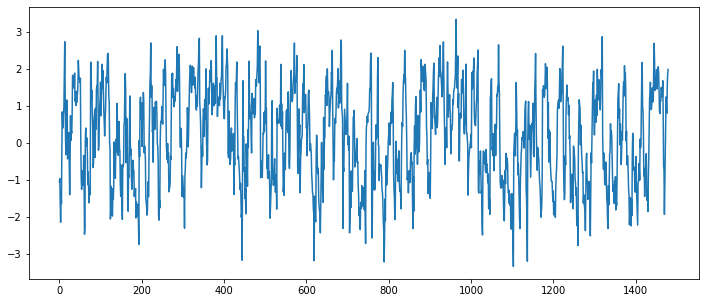

In [21]:
MA7_z_value_data = DF_price[['MA14;z_value;']]

plt.figure(figsize = (12, 5))
plt.plot(MA7_z_value_data)
plt.show()

In [22]:
test = DF_price['MA14;z_value;'].dropna()

In [23]:
test = test[::-1].reset_index()

In [25]:
test =  test[['MA14;z_value;']]

In [26]:
test

,MA14;z_value;
0,1.98372
1,1.87056
2,1.56986
3,0.798831
4,0.887976
...,...
1475,-1.33317
1476,-2.14637
1477,-1.54952
1478,-0.965263


In [27]:
scaler = MinMaxScaler(feature_range = (-1, 1))

MA7_z_value_data = scaler.fit_transform(test)

In [28]:
MA7_z_value_data

array([[ 0.59445466],
       [ 0.56058407],
       [ 0.47058184],
       ...,
       [-0.46309153],
       [-0.28821531],
       [-0.31715377]])

In [29]:
train = MA7_z_value_data[0:1121]
test = MA7_z_value_data[1121:]

In [30]:
test

array([[-0.0406919 ],
       [ 0.07333271],
       [ 0.59948215],
       [ 0.19135433],
       [ 0.32360055],
       [ 0.3511212 ],
       [ 0.05238042],
       [ 0.22342142],
       [ 0.27574897],
       [ 0.17687848],
       [-0.10739202],
       [-0.0229604 ],
       [-0.18278086],
       [-0.36277269],
       [-0.01111759],
       [ 0.1675756 ],
       [ 0.26655225],
       [ 0.32504135],
       [ 0.84673496],
       [ 0.81600597],
       [ 0.64470141],
       [ 0.59085371],
       [ 0.4448941 ],
       [ 0.29710127],
       [ 0.37954462],
       [ 0.26555184],
       [ 0.28755893],
       [ 0.37380403],
       [ 0.53235033],
       [ 0.44470115],
       [ 0.49834919],
       [ 0.50957689],
       [ 0.61033535],
       [ 0.50774242],
       [ 0.46830629],
       [ 0.62184827],
       [ 0.55678025],
       [ 0.40617636],
       [ 0.48933169],
       [ 0.59090968],
       [ 0.62852536],
       [ 0.57047124],
       [ 0.45489242],
       [ 0.29484607],
       [ 0.10099618],
       [-0

### 1) 학습생성 데이터 생성 함수 정의

In [ ]:
# # time_priod 몃일간 데이터를 줄것인가?
# def create_dataset(time_data, time_priod , prediction):
#   data_X, data_y = [], []

#   for i in range(len(time_date) - time_priod):
#     date_X.append(time_data[i+1:(i+1 + time_priod), 0])
#     date_y.append(time_data[i+1 - prediction, 0])

#   return np.array(data_X), np.array(data_y)

In [31]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

In [32]:
look_back = 28

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

In [ ]:
# time_priod = 7
# prediction = 1

# train_X, train_y = create_dataset(train, time_priod, prediction)
# test_X,  test_y  = create_dataset(test, time_priod, prediction)

# train_X.shape, train_y.shape, test_X.shape, test_y.shape

NameError: ignored

In [33]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1093, 28, 1), (1093,), (331, 28, 1), (331,))

## V.LSTM 모델

In [34]:
model = Sequential(name = 'LSTM')
model.add(LSTM(128, 
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [35]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

In [37]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
69/69 [==============================] - 8s 19ms/step - loss: 0.0826 - val_loss: 0.0607
Epoch 2/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0580 - val_loss: 0.0497
Epoch 3/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0486 - val_loss: 0.0474
Epoch 4/200
69/69 [==============================] - 1s 12ms/step - loss: 0.0453 - val_loss: 0.0432
Epoch 5/200
69/69 [==============================] - 1s 12ms/step - loss: 0.0436 - val_loss: 0.0418
Epoch 6/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0430 - val_loss: 0.0415
Epoch 7/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0430 - val_loss: 0.0413
Epoch 8/200
69/69 [==============================] - 1s 12ms/step - loss: 0.0427 - val_loss: 0.0437
Epoch 9/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0434 - val_loss: 0.0413
Epoch 10/200
69/69 [==============================] - 1s 11ms/step - loss: 0.0429 - val_loss: 0.0414

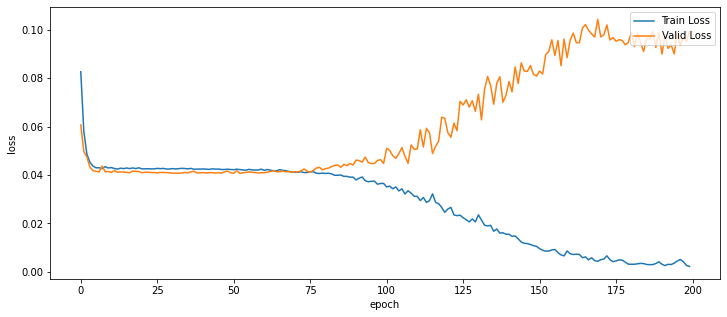

In [38]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

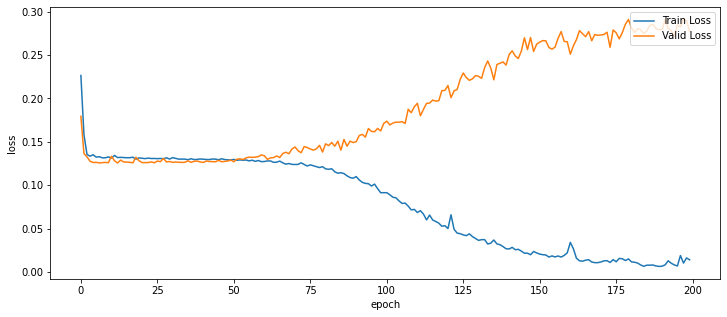

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [39]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.0018862022552639246
Test Score:  0.09945763647556305


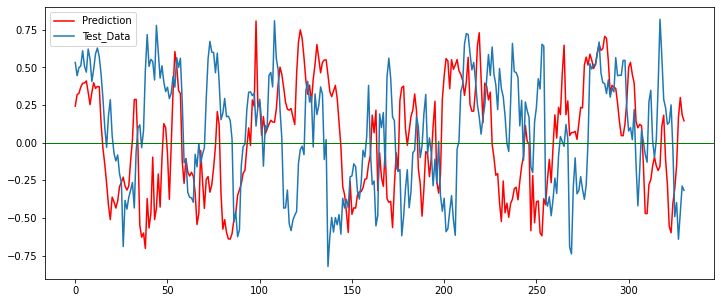

In [42]:
look_ahead = 331

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')


# plt.axhline(y=2.5, color='b', linewidth=1)
# plt.axhline(y=-2.5, color='b', linewidth=1)

plt.axhline(y=0, color='g', linewidth=1)

plt.legend()
plt.show()

In [43]:
predictions

array([[ 0.2423213 ],
       [ 0.31881759],
       [ 0.32786557],
       [ 0.37016237],
       [ 0.39410993],
       [ 0.39632383],
       [ 0.40981111],
       [ 0.33461869],
       [ 0.25254205],
       [ 0.33432212],
       [ 0.39763302],
       [ 0.35995686],
       [ 0.37305108],
       [ 0.37222689],
       [ 0.12790118],
       [-0.03726723],
       [-0.14267677],
       [-0.27145243],
       [-0.41583684],
       [-0.51162809],
       [-0.3617135 ],
       [-0.39315045],
       [-0.43452716],
       [-0.38813567],
       [-0.29262856],
       [-0.26309681],
       [-0.22939701],
       [-0.28878161],
       [-0.31497511],
       [-0.28896075],
       [-0.1229022 ],
       [ 0.02029919],
       [ 0.2861169 ],
       [ 0.28773478],
       [-0.03711022],
       [-0.54927409],
       [-0.62808007],
       [-0.60042119],
       [-0.70308727],
       [-0.3713901 ],
       [-0.56733799],
       [-0.46976784],
       [-0.09625462],
       [-0.51150215],
       [-0.43631661],
       [-0

## IV. EDA z_value

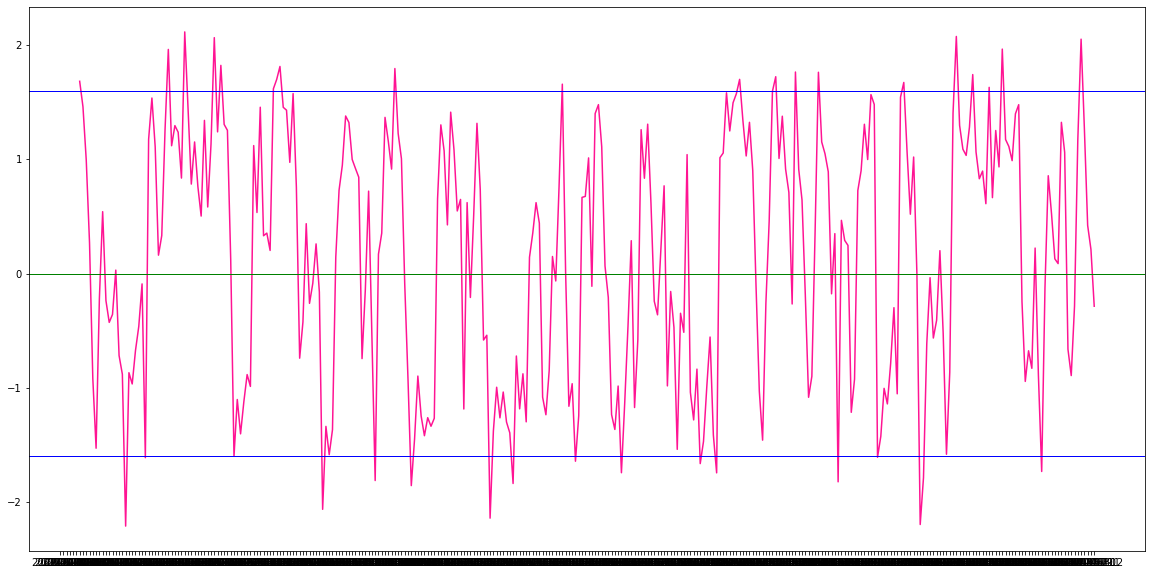

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=1.6, color='b', linewidth=1)
plt.axhline(y=-1.6, color='b', linewidth=1)

plt.show()


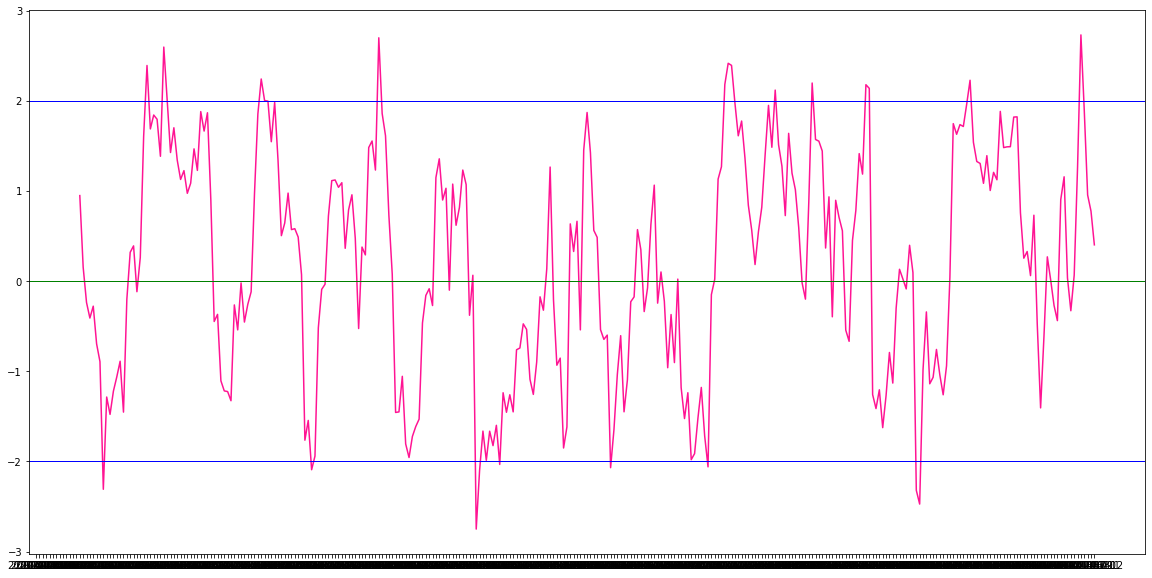

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2, color='b', linewidth=1)
plt.axhline(y=-2, color='b', linewidth=1)

plt.show()



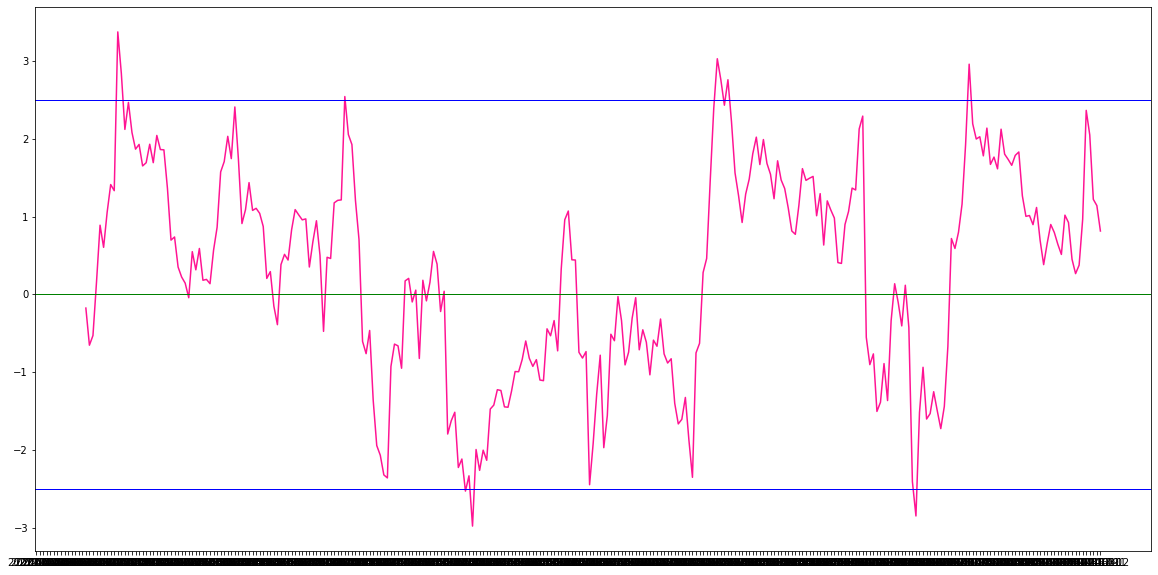

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
plt.axhline(y=2.5, color='b', linewidth=1)
plt.axhline(y=-2.5, color='b', linewidth=1)

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


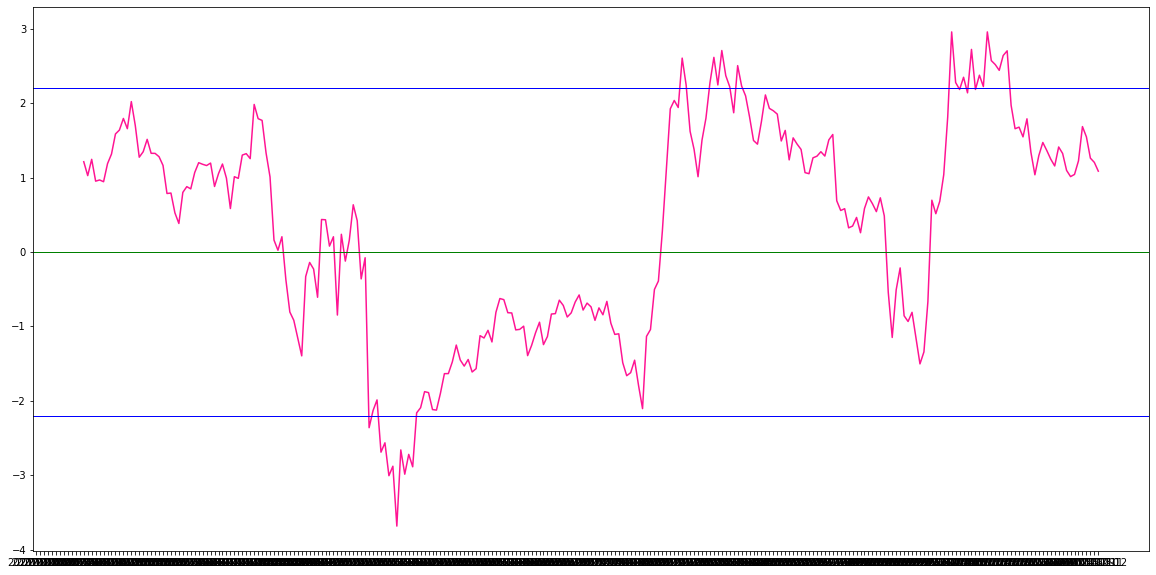

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2.2, color='b', linewidth=1)
plt.axhline(y=-2.2, color='b', linewidth=1)

plt.show()

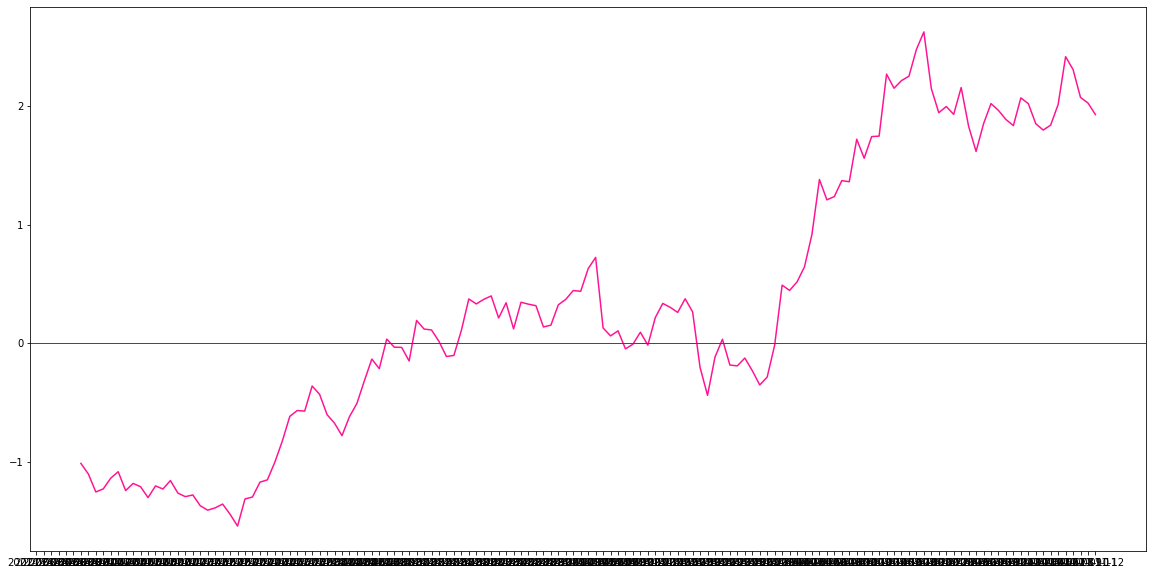

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## V. z_value 평균이동선 작업밎 EDA

In [ ]:
  for i in n:
    DF_price['MA{0};z_value;MA{0};'.format(i)]= DF_price['MA{0};z_value;'.format(i)].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};''MA{0};z_value;MA{0};'.format(i))

완료 MA7;MA7;z_value;MA7;
완료 MA14;MA14;z_value;MA14;
완료 MA30;MA30;z_value;MA30;
완료 MA60;MA60;z_value;MA60;
완료 MA180;MA180;z_value;MA180;


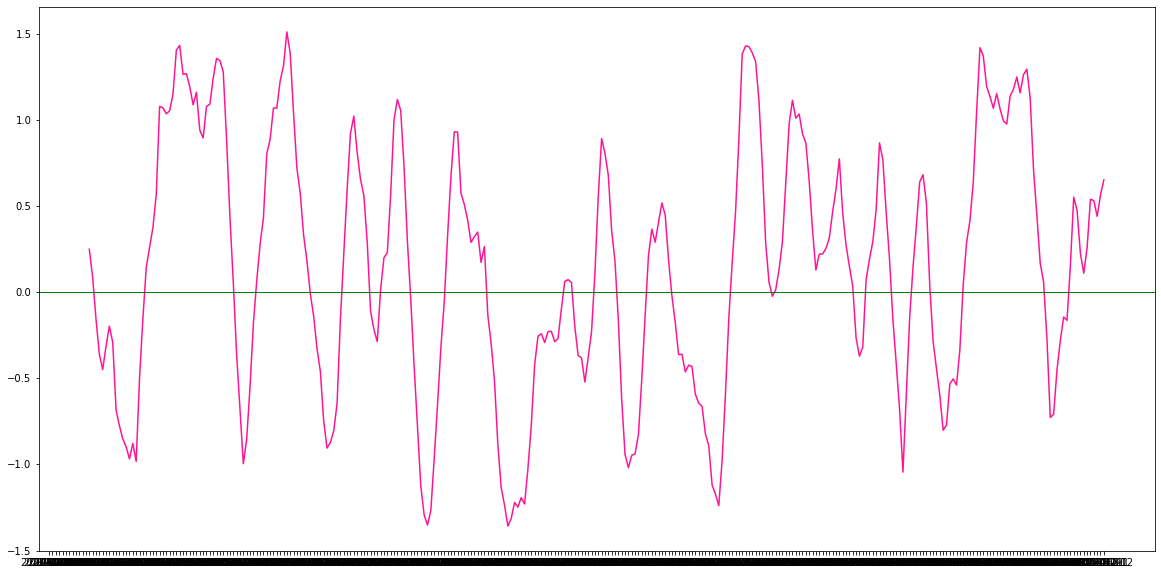

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;MA7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


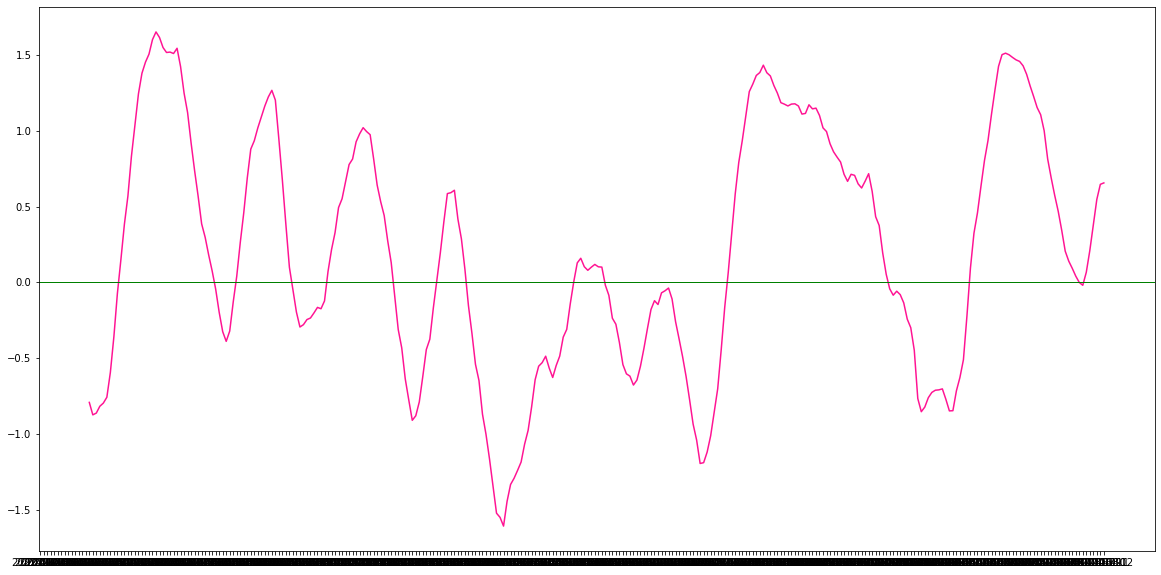

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;MA14;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

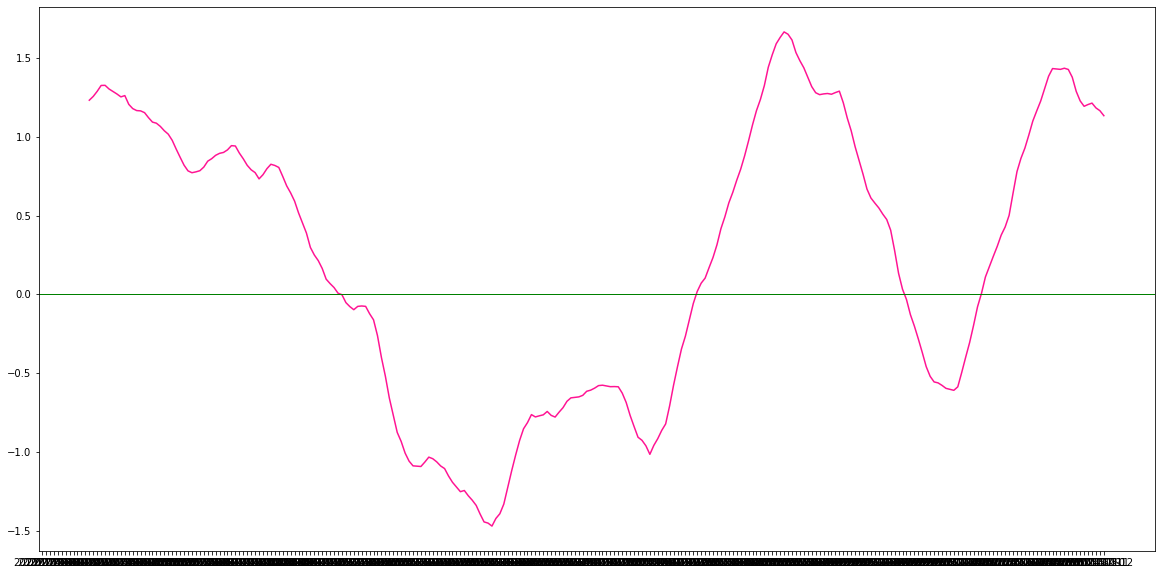

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;MA30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

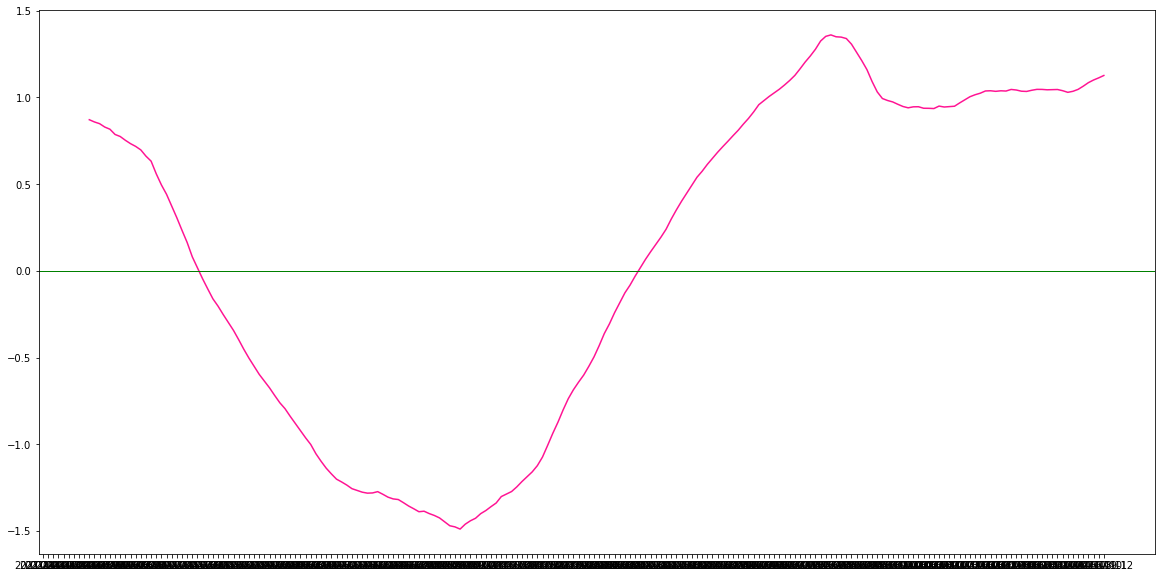

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;MA60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

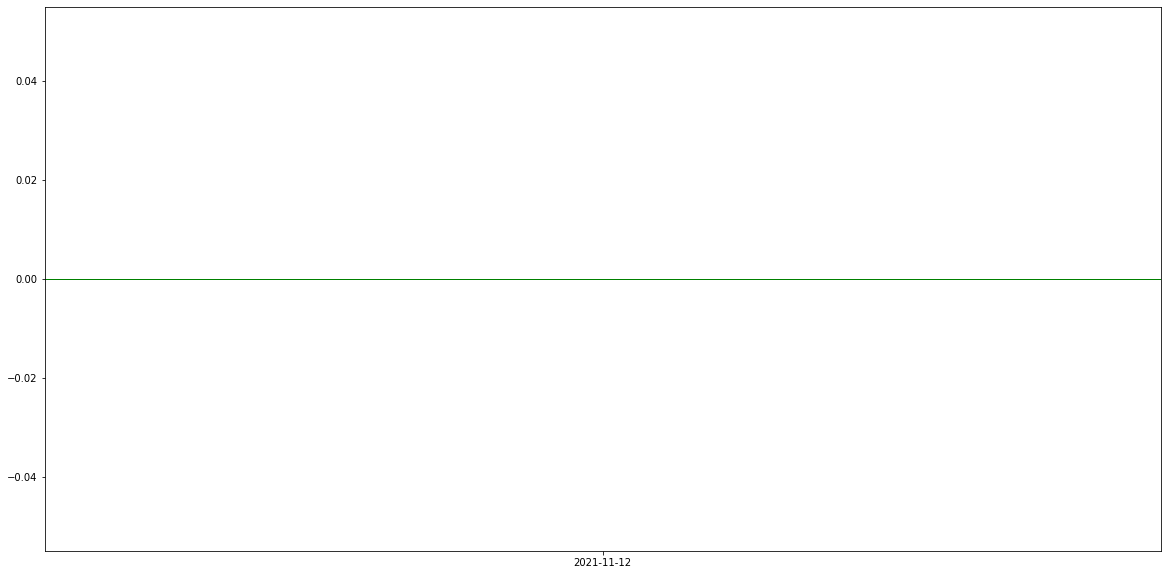

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;MA180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## VI. 이격도(disparity) 작업 밎 EDA

In [ ]:
DF_price['disparity7;']= DF_price['price']/DF_price['MA7;']
DF_price['disparity14;']= DF_price['price']/DF_price['MA14;']
DF_price['disparity30;']= DF_price['price']/DF_price['MA30;']
DF_price['disparity60;']= DF_price['price']/DF_price['MA60;']
DF_price['disparity180;']= DF_price['price']/DF_price['MA180;']

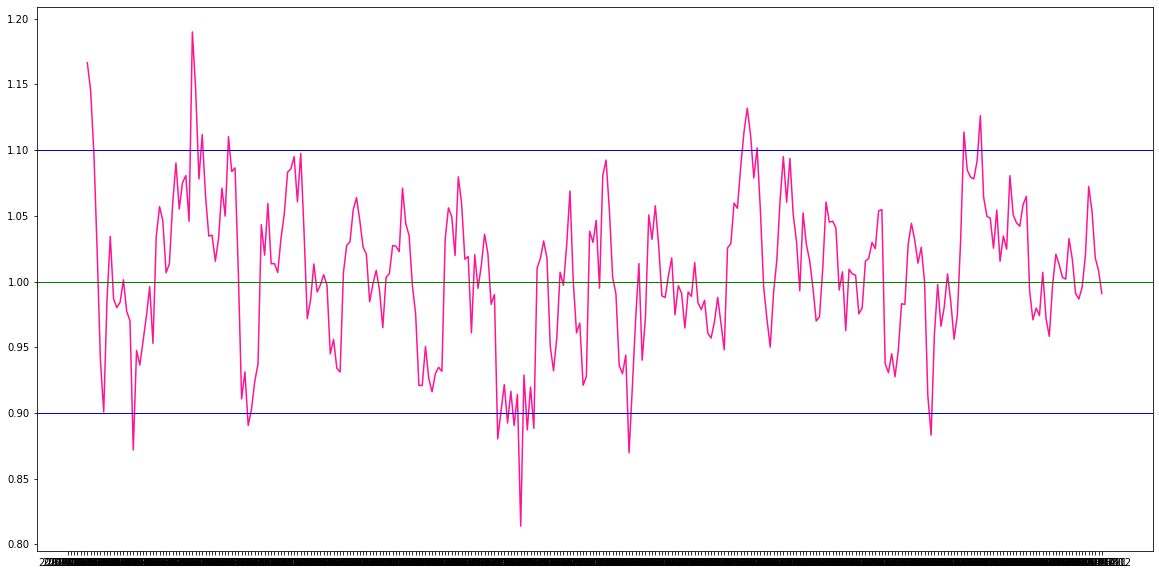

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)
plt.axhline(y=1.1, color='b', linewidth=1)
plt.axhline(y=0.90, color='b', linewidth=1)

plt.show()


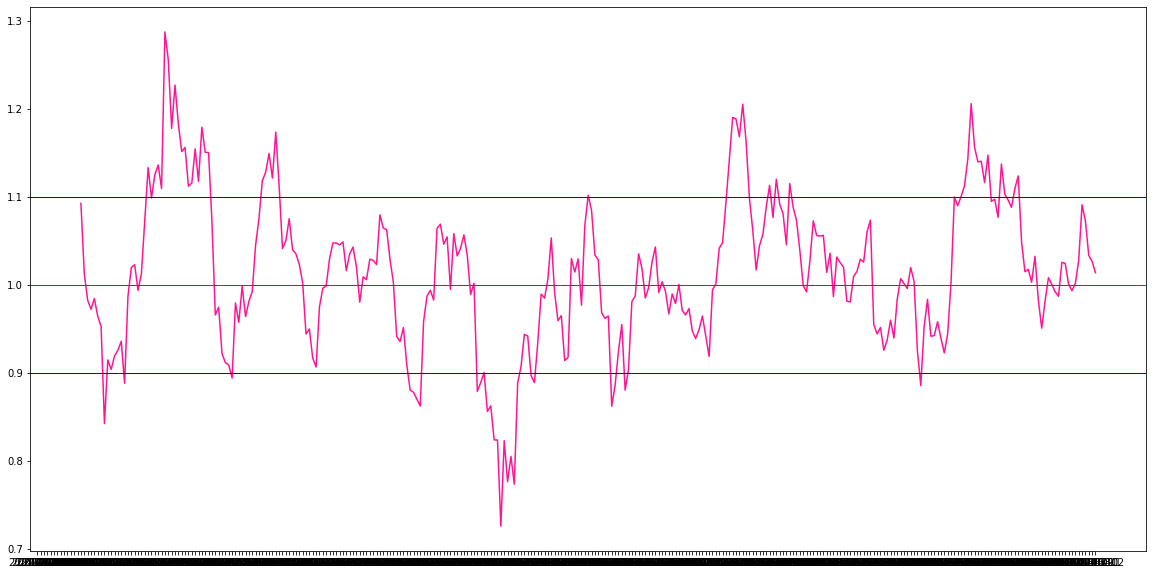

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity14;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
plt.axhline(y=1.1, color='b', linewidth=1)
plt.axhline(y=0.90, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


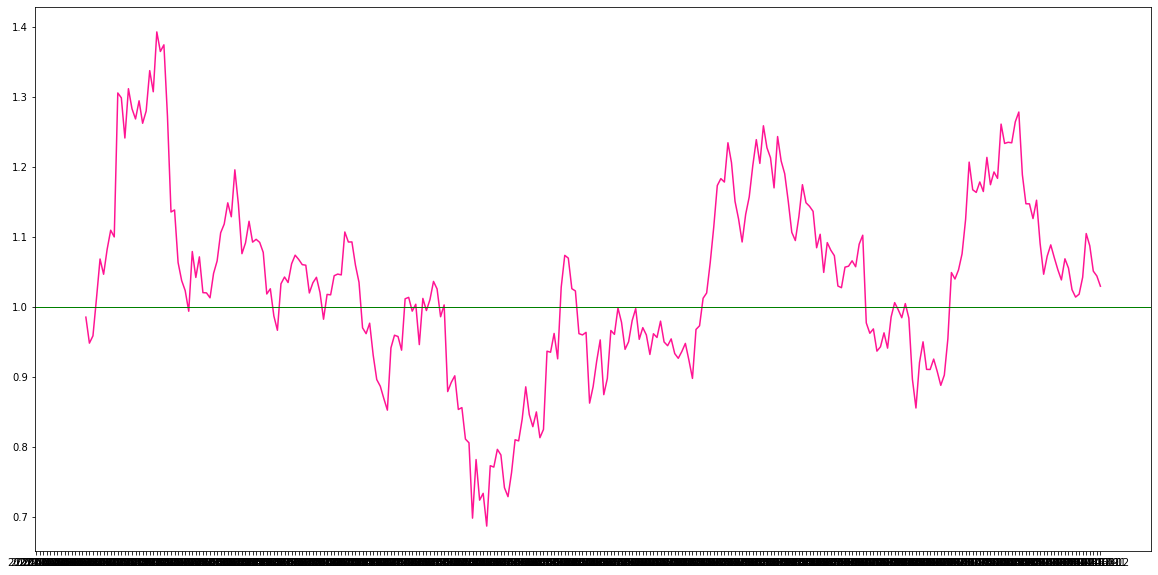

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
# plt.axhline(y=1.25, color='b', linewidth=1)
# plt.axhline(y=0.75, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


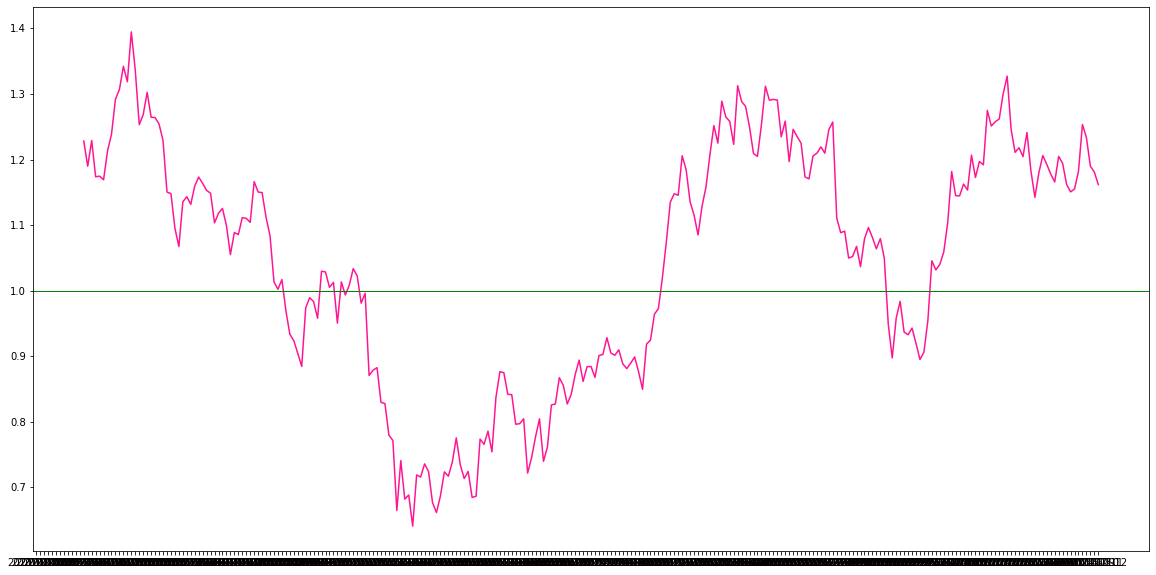

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


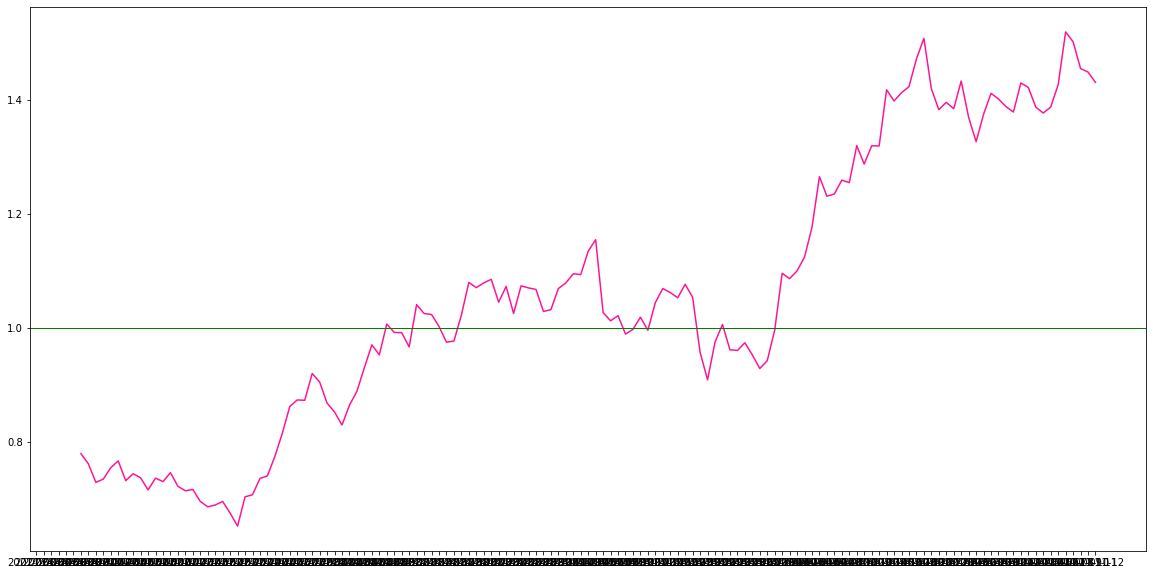

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()